In [1]:
# PoMiASI Project
# This notebook analyzes data exported to a CSV file,
# where each line represents a single HTTP request and its corresponding response.
#
# Scope of analysis:
# - Total page load time
# - Average object download time
# - Number of concurrent downloads over time
# - Time gaps between downloads within a single TCP connection (client_port)
# - Gantt chart visualizing file downloads over time
#
# Input data from CSV:
# first_timestamp_ms, last_timestamp_ms, duration_ms, total_bytes, request_uri, client_port, request_user_agent
#
# ------------------------------------------------------------
# CHANGELOG – Version 3.0
#
# - Zastąpiono drop_two_shortest filtrem po rozmiarze (total_bytes >= 1 MB) dla wybranych statystyk.
# - Dodano obsługę i kontrolę poprawności completion_procent; kluczowe analizy czasowe liczone są tylko dla wierszy z wartością 100%.
# - Dodano kolumny pochodne: size_kb, duration_s, speed_kb_per_s.
# - Ulepszono wykrywanie przeglądarki (Chrome, Edge, Opera, Firefox, Safari, Brave, Other).
# - Zaktualizowano wykres „Active downloads over time” do postaci podwykresów per przeglądarka (ułożonych pionowo).
# - Przebudowano „Download time per object” na boxplot per przeglądarka (bez mieszania różnych URI w jednym wykresie).
# - Zmieniono wykres porównania przeglądarek na boxplot (obiekty >= 1 MB).
# ------------------------------------------------------------


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from IPython.display import display

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 5)


In [3]:
# ---------------------------------------------------------
# Wczytanie CSV
# ---------------------------------------------------------

csv_path = "/content/output.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"File not found: {csv_path}")

df = pd.read_csv(csv_path)

required = [
    'first_timestamp_ms',
    'last_timestamp_ms',
    'duration_ms',
    'total_bytes',
    'request_uri',
    'client_port'
]
missing = [col for col in required if col not in df.columns]
if missing:
    raise ValueError(f"Missing columns in CSV: {', '.join(missing)}")

# Podstawowe konwersje typów
df['first_timestamp'] = pd.to_datetime(df['first_timestamp_ms'], unit='ms', utc=True)
df['last_timestamp'] = pd.to_datetime(df['last_timestamp_ms'], unit='ms', utc=True)
df['duration_ms'] = df['duration_ms'].astype(float)
df['total_bytes'] = df['total_bytes'].astype(float)

# completion_procent – sanity check
if 'completion_procent' in df.columns:
    df['completion_procent'] = df['completion_procent'].astype(float)
    completion_ok = df['completion_procent'] == 100.0
    print("completion_procent summary:")
    print(df['completion_procent'].describe())
    print(f"Rows with completion_procent == 100: {completion_ok.sum()} / {len(df)}")
    df_complete = df[completion_ok].copy()
else:
    print("No 'completion_procent' column – assuming all rows are complete.")
    df['completion_procent'] = np.nan
    df_complete = df.copy()

# Dodatkowe kolumny – rozmiar, czas w sekundach, prędkość
df_complete['size_kb'] = df_complete['total_bytes'] / 1024.0
df_complete['duration_s'] = df_complete['duration_ms'] / 1000.0
df_complete['speed_kb_per_s'] = df_complete['size_kb'] / df_complete['duration_s'].replace(0, np.nan)


No 'completion_procent' column – assuming all rows are complete.


In [4]:
# ---------------------------------------------------------
# Identyfikacja przeglądarki po User-Agent
# ---------------------------------------------------------

def get_browser(user_agent: str) -> str:
    if pd.isna(user_agent):
        return "Unknown"
    ua = user_agent.lower()

    # Kolejność ważna – Edge/Opera/Brave przed "gołym" Chrome
    if "firefox" in ua:
        return "Firefox"
    if "edg/" in ua or " edge/" in ua:
        return "Edge"
    if "opr/" in ua or "opera" in ua:
        return "Opera"
    if "brave" in ua:
        return "Brave"
    if "chrome" in ua and "chromium" not in ua:
        return "Chrome"
    if "safari" in ua and "chrome" not in ua:
        return "Safari"
    return "Other"

if 'request_user_agent' in df_complete.columns:
    df_complete['browser'] = df_complete['request_user_agent'].apply(get_browser)
else:
    df_complete['browser'] = "Unknown"

# Na razie pojedynczy attempt – jak będzie potrzeba, można nadać różne numery.
df_complete['attempt'] = 1

# Podstawowe metryki (na kompletnych danych)
total_time_ms = (df_complete['last_timestamp'].max() - df_complete['first_timestamp'].min()).total_seconds() * 1000
avg_duration_ms = df_complete['duration_ms'].mean()
total_bytes_sum = df_complete['total_bytes'].sum()

print(f"Total page load time (from first to last packet): {total_time_ms:.1f} ms")
print(f"Average object download time: {avg_duration_ms:.1f} ms")
print(f"Total data transferred (complete rows): {total_bytes_sum/1024/1024:.2f} MB")
print(f"Objects analyzed (complete rows): {len(df_complete)}")


Total page load time (from first to last packet): 512597465.0 ms
Average object download time: 1142.2 ms
Total data transferred (complete rows): 3943.98 MB
Objects analyzed (complete rows): 186


In [5]:
# ---------------------------------------------------------
# 1. Filtr obiektów >= 1 MB dla wybranych statystyk
# ---------------------------------------------------------

ONE_MB = 1024 * 1024
df_large = df_complete[df_complete['total_bytes'] >= ONE_MB].copy()

print(f"Objects >= 1 MB (complete rows): {len(df_large)}")


Objects >= 1 MB (complete rows): 184


In [6]:
# ---------------------------------------------------------
# 2. Statystyki czasu pobierania (trimming po rozmiarze, nie po czasie)
# ---------------------------------------------------------

duration_stats = (
    df_large
    .groupby(['browser', 'attempt'])['duration_ms']
    .agg(['count', 'mean', 'median', 'min', 'max'])
    .reset_index()
)

print("\nDownload duration stats (objects >= 1 MB):")
display(duration_stats)



Download duration stats (objects >= 1 MB):


,browser,attempt,count,mean,median,min,max
0,Chrome,1,92,1448.119565,1503.0,286.0,2876.0
1,Opera,1,92,861.043478,740.0,201.0,2858.0


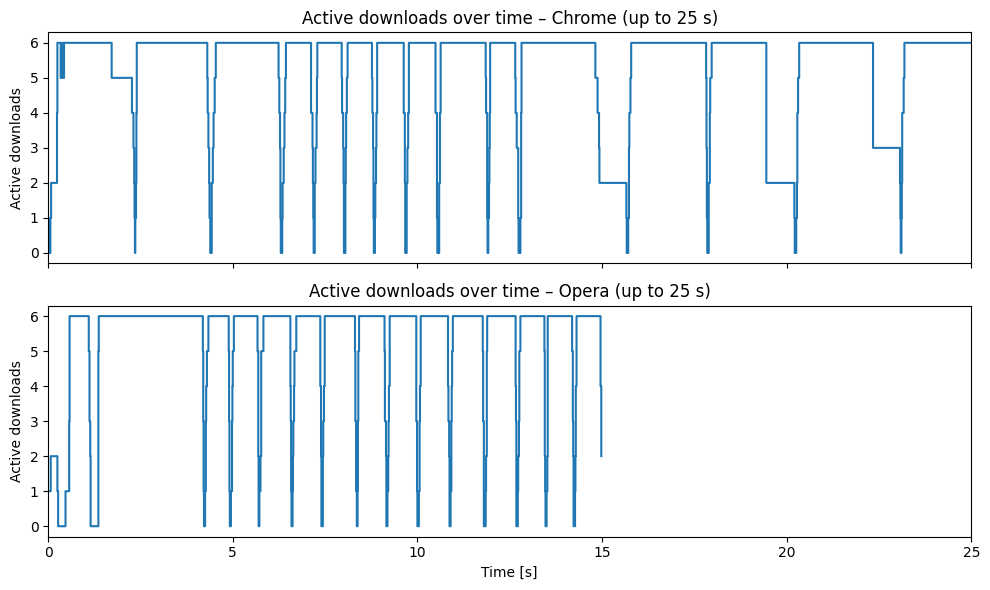

In [7]:
# ---------------------------------------------------------
# 3. Liczba równoczesnych downloadów w czasie (per przeglądarka, subplots)
# ---------------------------------------------------------

def active_downloads(df_sub, max_time_s=25):
    if df_sub.empty:
        return np.array([]), np.array([])
    t0 = df_sub['first_timestamp'].min()
    tend = df_sub['last_timestamp'].max()
    freq = '10ms'
    ts_all = pd.date_range(t0, tend, freq=freq)
    rel_time = (ts_all - t0).total_seconds()
    rel_time = rel_time[rel_time <= max_time_s]
    ts_all = ts_all[:len(rel_time)]

    active_counts = []
    starts = df_sub['first_timestamp']
    ends = df_sub['last_timestamp']
    for t in ts_all:
        active_counts.append(((starts <= t) & (ends >= t)).sum())
    return rel_time, np.array(active_counts)

browsers = sorted(df_complete['browser'].unique())
n_browsers = len(browsers)

if n_browsers > 0:
    fig, axes = plt.subplots(n_browsers, 1, sharex=True, figsize=(10, 3 * n_browsers))
    if n_browsers == 1:
        axes = [axes]

    for ax, bname in zip(axes, browsers):
        g = df_complete[df_complete['browser'] == bname]
        xs, ys = active_downloads(g)
        ax.step(xs, ys, where='post')
        ax.set_ylabel('Active downloads')
        ax.set_title(f'Active downloads over time – {bname} (up to 25 s)')
        ax.set_xlim(0, 25)

    axes[-1].set_xlabel('Time [s]')
    plt.tight_layout()
    plt.show()
else:
    print("No browsers detected – cannot plot active downloads.")


In [8]:
# ---------------------------------------------------------
# 4. Procentowy rozkład liczby równoczesnych downloadów
# ---------------------------------------------------------

def active_distribution(df_sub):
    if df_sub.empty:
        return pd.DataFrame(columns=['active', 'dt', 'percent'])

    events = []
    for s, e in zip(df_sub['first_timestamp'], df_sub['last_timestamp']):
        events.append((s, +1))
        events.append((e, -1))
    events.sort()

    active = 0
    last_t = events[0][0]
    spans = []

    for t, delta in events:
        if t > last_t:
            spans.append({
                'active': active,
                'dt': (t - last_t).total_seconds()
            })
        active += delta
        last_t = t

    dist = pd.DataFrame(spans).groupby('active', as_index=False)['dt'].sum()
    total = dist['dt'].sum()
    dist['percent'] = 100 * dist['dt'] / total if total > 0 else 0.0
    return dist

dist_all = []
for (b, a), g in df_complete.groupby(['browser', 'attempt']):
    d = active_distribution(g)
    d['browser'] = b
    d['attempt'] = a
    dist_all.append(d)

if dist_all:
    dist_all = pd.concat(dist_all, ignore_index=True)
    print("\nActive download distribution (% of time):")
    display(dist_all)
else:
    print("No data for active download distribution.")



Active download distribution (% of time):


,active,dt,percent,browser,attempt
0,0,0.565,2.244468,Chrome,1
1,1,0.285,1.132165,Chrome,1
2,2,1.964,7.802010,Chrome,1
3,3,0.998,3.964565,Chrome,1
4,4,0.599,2.379534,Chrome,1
5,5,0.946,3.757995,Chrome,1
6,6,19.816,78.719263,Chrome,1
7,0,0.876,5.845846,Opera,1
8,1,0.470,3.136470,Opera,1
9,2,0.360,2.402402,Opera,1



Time gaps stats (per browser/attempt):


,browser,attempt,count,mean,median,min,max
0,Chrome,1,88,188.693182,90.5,7.0,895.0
1,Opera,1,86,96.034884,84.0,31.0,319.0


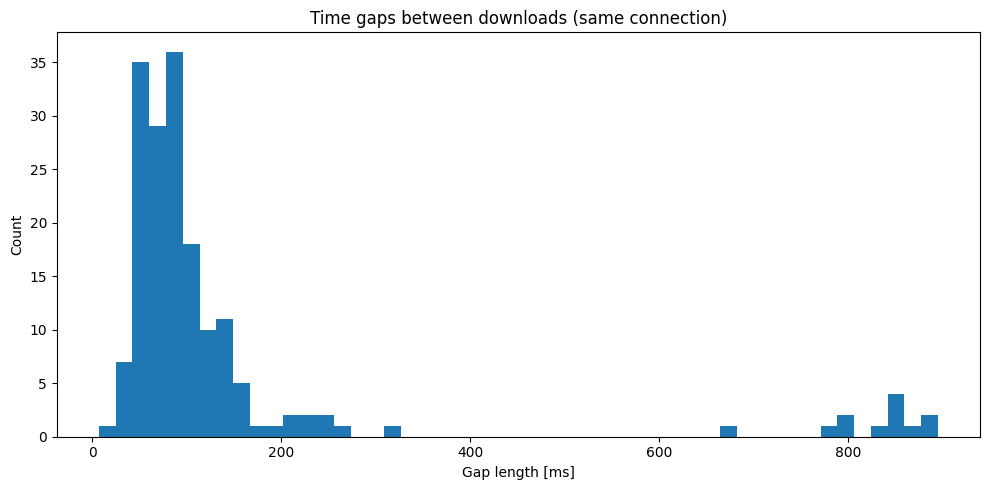

In [9]:
# ---------------------------------------------------------
# 5. Time gaps – statystyki i histogram
# ---------------------------------------------------------

gaps = []
for (b, a, port), g in df_complete.sort_values('first_timestamp').groupby(['browser', 'attempt', 'client_port']):
    ends = g['last_timestamp'].shift(1)
    starts = g['first_timestamp']
    gap = (starts - ends).dt.total_seconds() * 1000.0  # ms
    gaps.extend((b, a, x) for x in gap[gap > 0].dropna())

gaps_df = pd.DataFrame(gaps, columns=['browser', 'attempt', 'gap_ms'])

if not gaps_df.empty:
    gaps_stats = (
        gaps_df.groupby(['browser', 'attempt'])['gap_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )
    print("\nTime gaps stats (per browser/attempt):")
    display(gaps_stats)

    plt.figure()
    plt.hist(gaps_df['gap_ms'], bins=50)
    plt.title('Time gaps between downloads (same connection)')
    plt.xlabel('Gap length [ms]')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("No positive time gaps found – nothing to plot.")


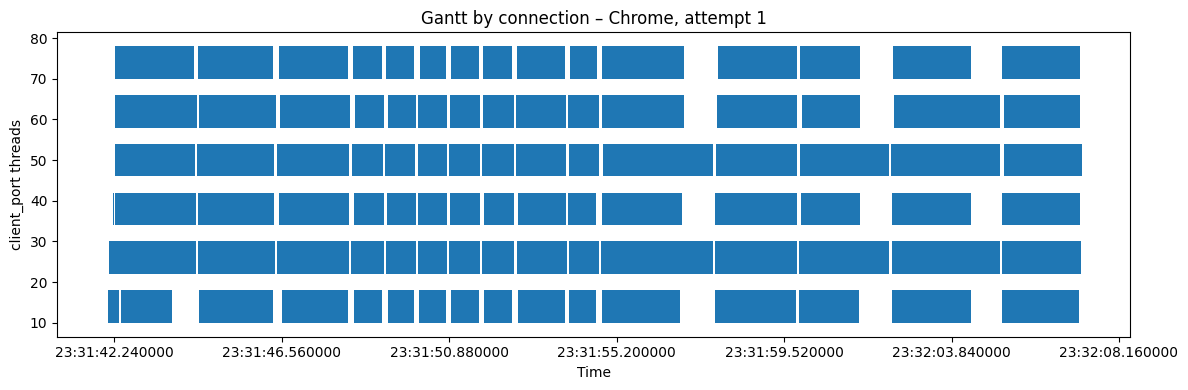

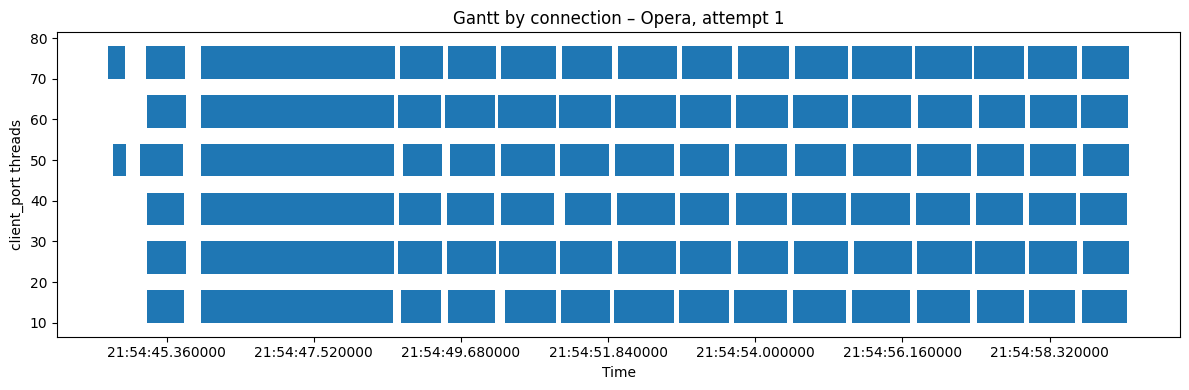

In [10]:
# ---------------------------------------------------------
# 6. Gantt chart ze względu na client_port
# ---------------------------------------------------------

df_gantt = df_complete.copy()
df_gantt['order_in_port'] = (
    df_gantt.sort_values('first_timestamp')
    .groupby(['browser', 'attempt', 'client_port'])
    .cumcount() + 1
)

for (b, a), g in df_gantt.groupby(['browser', 'attempt']):
    if g.empty:
        continue

    ports = sorted(g['client_port'].unique())
    plt.figure(figsize=(12, max(4, len(ports) * 0.3)))
    y = 10

    for port in ports:
        gt = g[g['client_port'] == port].sort_values('first_timestamp')
        for _, row in gt.iterrows():
            start = mdates.date2num(row['first_timestamp'])
            width = (row['last_timestamp'] - row['first_timestamp']).total_seconds() / 86400.0
            plt.broken_barh([(start, width)], (y, 8))
        y += 12

    plt.title(f'Gantt by connection – {b}, attempt {a}')
    plt.xlabel('Time')
    plt.ylabel('client_port threads')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1768928343.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=browsers_for_box, showfliers=True)


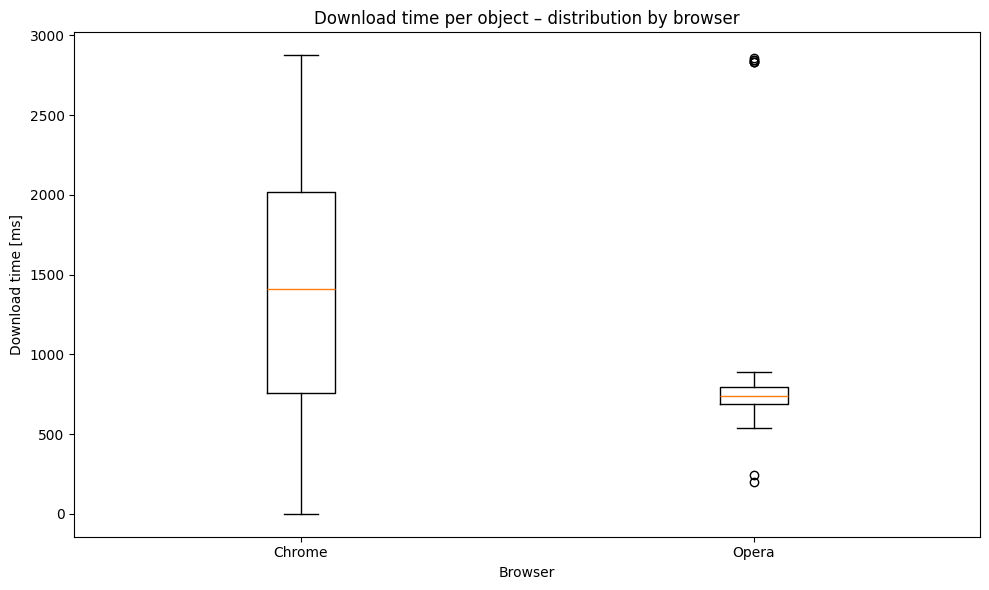

In [11]:
# ---------------------------------------------------------
# 7. Czas pobierania pojedynczych obiektów – boxplot per przeglądarka
# (bez progu 1 MB, *nie mieszać URI + przeglądarek w jednym barh)
# ---------------------------------------------------------

if not df_complete.empty:
    browsers_for_box = sorted(df_complete['browser'].unique())
    data_box = [df_complete[df_complete['browser'] == b]['duration_ms'] for b in browsers_for_box]

    plt.figure(figsize=(10, 6))
    plt.boxplot(data_box, labels=browsers_for_box, showfliers=True)
    plt.xlabel('Browser')
    plt.ylabel('Download time [ms]')
    plt.title('Download time per object – distribution by browser')
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot download time per object.")



Cross-browser comparison (objects >= 1 MB):


,browser,count,mean,median,min,max
0,Chrome,92,1448.119565,1503.0,286.0,2876.0
1,Opera,92,861.043478,740.0,201.0,2858.0


/tmp/ipython-input-1559820961.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_large, labels=browsers_large, showfliers=True)


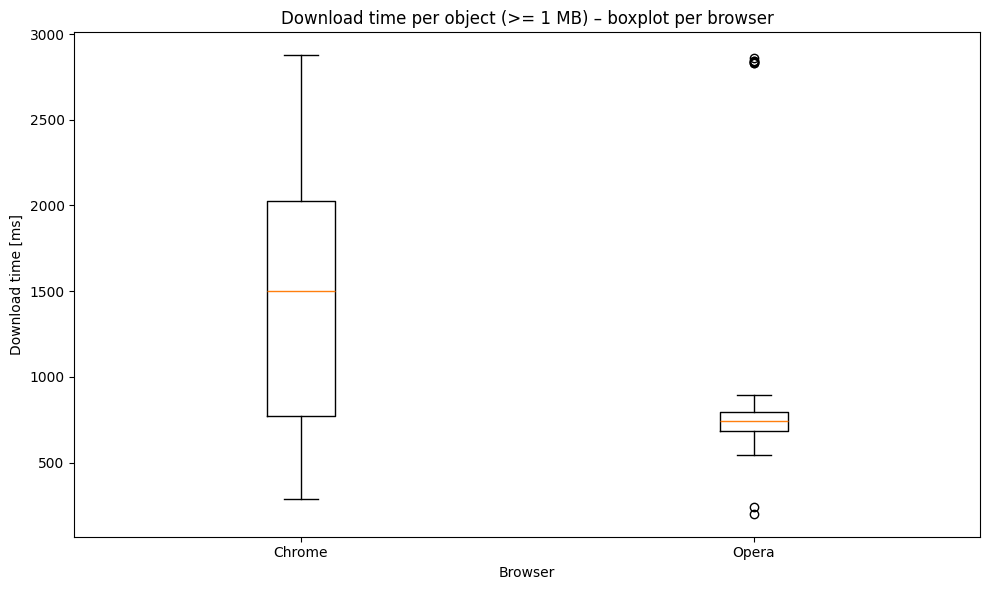


Wszystko sekcje wykonane pomyślnie endif.


In [12]:
# ---------------------------------------------------------
# 8. Podsumowanie porównania – statystyki + boxplot (>= 1 MB)
# ---------------------------------------------------------

if not df_large.empty:
    browser_cmp = (
        df_large.groupby('browser')['duration_ms']
        .agg(['count', 'mean', 'median', 'min', 'max'])
        .reset_index()
    )
    print("\nCross-browser comparison (objects >= 1 MB):")
    display(browser_cmp)

    browsers_large = sorted(df_large['browser'].unique())
    data_large = [df_large[df_large['browser'] == b]['duration_ms'] for b in browsers_large]

    plt.figure(figsize=(10, 6))
    plt.boxplot(data_large, labels=browsers_large, showfliers=True)
    plt.xlabel('Browser')
    plt.ylabel('Download time [ms]')
    plt.title('Download time per object (>= 1 MB) – boxplot per browser')
    plt.tight_layout()
    plt.show()
else:
    print("No objects >= 1 MB to compare across browsers.")

print("\nWszystko sekcje wykonane pomyślnie endif.")
